# Оптимизация обработки стали

Заказчик работы — металлургический комбинат. Цель исследования: сократить производственные расходы за счет оптимизации потребления электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

Технологический процесс обработки стали выглядит следующим образом:

Сталь обрабатывают в металлическом ковше, облицованным изнутри огнеупорным кирпичом, вместимостью около 100 тонн. В ковш заливают расплавленную сталь и подогревают до нужной температуры графитовыми электродами, установленными в крышке ковша. 

Затем из сплава выводится сера (десульфурация), и за счет добавления примесей корректируется его химический состав . Для проверки состава отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## <a id ='section_1'></a> Обзор данных

### Импорт библиотек

Перед загрузкой данных о процессе импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor               # константая модель для проверки "адекватности" работы основной

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Загрузка данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Загрузим каждый датасет и последовательно изучим их содержимое.

In [2]:
try:
    data_arc = pd.read_csv('data_arc.csv')
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv')
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')
    
except: 
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Данные об электродах

Изучим содержимое первого датасета `data_arc`

In [3]:
data_arc.head(20) # выводим первые 20 строк data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Датасет содержит индексный столбец и 5 признаков. Обратим внимание, что для одной партии (признак `key`) возможно разное количество итераций — например, партия под номером 1 нагревалась 5 раз (индексы 0 - 4), а партия 2 — 4 раза. Посмотрим максимальное и минимальное количество итераций.

In [4]:
# строим сводную таблицу, группируя данные по номеру партии
data_arc.pivot_table(index='key',
                     values='Начало нагрева дугой',
                     aggfunc=('count')).sort_values('Начало нагрева дугой', ascending = False)

,Начало нагрева дугой
key,
2108,16
1513,15
1689,15
2567,14
46,13
...,...
112,1
2472,1
2025,1


Всего в датасете о работе электродов имеются данные о 3214 партиях стали — максимальное количество повторений нагрева равняется 16, при этом часть партий нагревали только 1 раз. Посмотрим на распределение количества нагревов электродами на гистограмме.

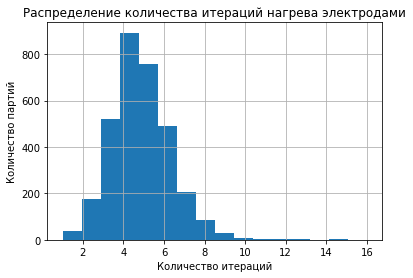

In [5]:
data_arc.pivot_table(index='key',
                     values='Начало нагрева дугой',
                     aggfunc=('count')).sort_values('Начало нагрева дугой', ascending = False).hist(bins=16)
plt.title('Распределение количества итераций нагрева электродами')
plt.xlabel('Количество итераций')
plt.ylabel('Количество партий')
plt.show()

График смещен вправо — в среднем партию стали надо нагреть элеткродами 4 раза, но некоторые нагревали более 10 раз — именно, предотвращение появления таких нетипичных случаев позволит сократить объем потребляемой электроэнергии.

Теперь посмотрим на агрегированные данные по столбцам

In [6]:
data_arc.describe() #используем метод .describe(), чтобы посмотреть агрегированные данные по столбцам

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Кажется, в данных имеются ошибки и выбросы — при медианном значении активной мощности ~ `0.56`, максимальное значение этого признака составляет `3.73`. В столбце с рективной мощностью имеются отрицательные значения, кроме того максимальное значение в несколько раз больше не только медианы, но и 75%-квартиля.

**ВАЖНО**: при агрегированнии данных по номеру партии мы получили 3214 строк — а максимальный номер партии 3241 — значит по ряду партий информация отсутствует.

In [7]:
# посмотрим на отрицательные значения реактивной мощности
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Только одна строка имеет отрицательную реактивную мощность — вероятно, все данные по этой партии (2116) необходимо отбросить.

Наконец, посмотрим общую информацию по датасету об электродах.

In [8]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков в данном датасете нет. 

### Данные о подаче сыпучих материалов

Переходим к датасету с данными об объемах подачи сыпучих материалов.

In [9]:
data_bulk.head(10) # выводим первые 10 строк data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


В датасете содержатся данные по добавлению в каждую партию одного из 15 вариантов сыпучих материалов. В глаза сразу бросается большое количество пропусков — посмотрим на общую информацию о датасете, чтобы понять "масштаб" пропусков:

In [10]:
data_bulk.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Первое на что нужно обратить внимание — количество партий `key` — в данном датасете их 3129 против 3214 в предыдущем — возможно, в какие то партии не добавляли сыпучие материалы, а возможно, по части партий нет данных.

Второе, что требует внимания — некоторые материалы почти не использовались (например, Bulk 8) — вероятно, партии с редкими добавлениями придется отбросить, т.к. из-за недостатчного количества информации, модель просто не сможет обучиться.

In [11]:
# выводим агрегированные математические показатели
data_bulk.describe() 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Пока такая агрегация не дает большой пользы — объекты с пропусками отбрасываются и это искажает все показатели. Что важно — первая и последняя партии в датасете имеют такие же номера как и в датасете об электродах, значит можно предположить, что в те партии, которые тут отсутствуют просто не добавляли сыпучие материалы для легирования.

### Данные о времени подачи сыпучих материалов

Данные о времени подачи сыпучих материалов хранится в отдельном датасете — посмотрим на него:

In [12]:
data_bulk_time.head(10) #первые 10 строк датасета

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


Пока можно заметить, что часть материалов подается вместе, а часть отдельно.

In [13]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Общие данные по датасету показывают, что количество записей о времени соответствует количеству записей о подаче материалов — т.е. в датасетах нет ошибки учета.

### Данные о продувке сплава газом

После каждой добавки легирующих материалов сплав продувают инертным газом. Информация о продувке также хранится  в отдельном датасете.

In [14]:
data_gas.head(10) #первые десять строк датасета о продувке сплава газом

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


В датасете имеется информация только об общем количестве примененного газа на партию — и отсутствует разбивка по этапам легирования.

Виден достаточно большой разброс по количеству примененного газа — возможно, оно связано с количеством нагревов (т.е. итераций для достижения кондиционного состояния стали). Сравним количество нагревов с количеством примененного газа — для этого вернемся к первому датасету с информацией о применении электродов.

In [15]:
data_arc.pivot_table(index='key',
                     values='Начало нагрева дугой',
                     aggfunc=('count')).head(10)

,Начало нагрева дугой
key,
1,5
2,4
3,5
4,4
5,4
6,4
7,4
8,4
9,5


Зависимость не наблюдается — например, 10 партия нагревалась 6 раз, но было применено всего 6,52 куб. м. газа, а 4 партия нагревалась 4 раза, но потребовала 18.84 куб. м. газа.

Посмотрим агрегированные данные по датасету:

In [16]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В датасете отсутствует информация о двух партиях, которые есть в датасете об электродах (3239 против 3241).

Заметим, что максимальное значение сильно превывает среднее и медианное — т.е. распределение (и график) будет растянуто вправо.

Посмотрим на распределение количества использованного газа.

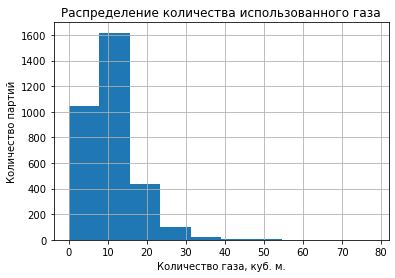

In [17]:
data_gas['Газ 1'].hist()
plt.title('Распределение количества использованного газа')
plt.xlabel('Количество газа, куб. м.')
plt.ylabel('Количество партий')
plt.show()


Минимальное значение близко к нулю — т.е. какой то партии продувка почти не понадобилась.

In [18]:
data_gas[data_gas['Газ 1'] < 0.01] # та самая партия, которая почти не потребовала газа

,key,Газ 1
863,866,0.008399


### Данные об измерении температуры

Данные об измерении температуры хранятся в датасете data_temp.

In [19]:
data_temp.head(10) #первые 10 строк датасета

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [20]:
data_temp.info() #общая информация по датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Видно, что в датасете имеются пропуски — температура отстутствует в 2901 записях (18% датасета). Т.к. именно температуру стали мы будем пытаться предсказать, необходимо разобраться с данными пропусками.

In [21]:
data_temp[data_temp['Температура'].isna()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Судя по всему, измерения температуры отстутствует для части партий целиком. 

In [22]:
data_temp[data_temp['Температура'].isna()].key.unique() # выводим номера партий,
                                                        # для которых отсутствует данные измерения температуры

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

Кажется, данные отсутствуют для партий с 2500 по 3241 — это 22% от общего числа партий — достаточно большое количество, учитывая что еще часть партий будет исключена из-за недостатка информации по применению редких сыпучих и проволочных материалов и других аномалий. Тем не менее, данные партии придется исключить, т.к. по ним не предсказать целевой признак.

Проверим пропуски на примере последней партии

In [23]:
data_temp[data_temp['key']==3241]

,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


На примере последней партии мы убедлись, что у некоторых партий есть часть замеров - но отсутствуют финальные замеры. Это следует учесть при удалении пропусков — стандартные методы удаления (dropna) оставят такие партии в датасете, и мы ошибочно будем учитывать промежуточные замеры температуры как финальные.

In [24]:
data_temp.describe() #агрегированные данные по датасету

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Из агрегированных данных нас интересует минимальное значение температуры — по информации от заказчика она не может быть меньше 1500 градусов, однако мы видим минимум равный 1191 градусам. Посмотрим на аномалии по данному признаку.

In [25]:
data_temp[data_temp['Температура']<1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Температура ниже 1500 может быть вызвана как ошибкой измерения, так и ошибкой технологического процесса. К счастью, таких объектов совсем немного — позднее нужно будет решить отбрасывать ли данные по партиям с этими номерами или оставить для обучения модели.

In [26]:
data_temp.pivot_table(index='key',
                      values = 'Температура',
                      aggfunc=('count')).sort_values(by='Температура', ascending = False). \
                      rename(columns={'Температура':'Количество измерений температуры'})

,Количество измерений температуры
key,
1214,16
44,16
1513,16
46,16
1689,15
...,...
2747,1
2748,1
2749,1


### Данные о проволочных материалах

Данные о примененных проволочных материалах хранятся в датасете data_wire

In [27]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет напоминает по своей структуре data_bulk — по каждой партии (`key`) имеются данных об использовании одного из 9 проволочных материалов — а если материал не применялся в столбце по объекту имеется пропуск.

In [28]:
data_wire.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Количество партий здесь также меньше чем в датасете о применении электродов — 3081 против 3214. Вероятно, не во все партии добавляли проволочные материалы.

### Данные о времени подачи проволочных материалов

Последний датасет хранит информацию о времени подачи проволочных материалов.

In [29]:
data_wire_time.head(10)  #первые десять строк

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проволочные материалы могут подаваться вместе или раздельно — например в 5 партии `Wire 1` и `Wire 2` подавались в разное время, а в 6 — вместе.

In [30]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Как и с сыпучими материалами количество записей о времени подачи совпадает с данными о самих материалах, то есть ошибок учета нет. Обратим внимание, что некоторые проволочные материалы почти не применялись — вероятно партии с их применением придется удалить, чтобы избежать ошибок обучения модели.

## Предобработка данных

### Обработка пропусков и аномальных значений

#### Пропуски в data_temp

При первичном анализе данных мы отметили, что по партиям с 2500 по 3241 отсутствуют измерения температуры. Именно температура является целевым признаком — и, соответственно, данные партии придется исключить из дальнейшей работы.

In [31]:
data_temp.info() # еще раз выведем информацию о датасете до удаления пропусков
                 # по целевому признаку

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [32]:
batches_with_na = list(data_temp[data_temp['Температура'].isna()].key.unique()) # создаем список с номерами партий,
                                                                                # где есть пропуски

In [33]:
data_temp = data_temp[~data_temp['key'].isin(batches_with_na)] # перезаписываем переменную

In [34]:
data_temp.info()               # повторно выводим информацию о датасете

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12267 non-null  int64  
 1   Время замера  12267 non-null  object 
 2   Температура   12267 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.3+ KB


После удаления пропусков с измерениями температуры в датасете осталось 12267 строк. Однако, нам надо еще удалить партии, в которых измерения показали температура менее 1500 градусов.

In [35]:
data_temp[data_temp['Температура']<1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0


In [36]:
batches_with_low_temp = list(data_temp[data_temp['Температура']<1500].key.unique()) # создаем список с номерами партий,
                                                                                    # где измерения показали низкую температуру

In [37]:
batches_with_low_temp

[867, 1214, 1619, 1818, 2052]

In [38]:
data_temp = data_temp[~data_temp['key'].isin(batches_with_low_temp)] # перезаписываем переменную

In [39]:
data_temp.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12223 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12223 non-null  int64  
 1   Время замера  12223 non-null  object 
 2   Температура   12223 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 382.0+ KB


#### Обработка аномалий в данных о добавлении сыпучих материалов

Часть сыпучих материалов почти не применялась — данных по ним будет недостаточно обучения модели — поэтому партии с использованием редких материалов исключим из дальнейшей работы.

In [40]:
data_bulk.info() # посмотрим еще раз информацию о том, как часто применялись разные сыпучие материалы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


`Bulk 8` применялся всего один раз — данную партию исключим как аномалию.
Сложнее обстоят дела с `Bulk 2`, `Bulk 7`, `Bulk 9` и `Bulk 13` — они применялись менее 30 раз т.е. менее чем в 1% случаев — однако, пока мы попробуем оставить их в датасете — модель должна уловить закономерности между их применением и температурой сплава.

In [41]:
data_bulk = data_bulk[data_bulk['Bulk 8'].isna()] # перезаписываем переменную с датасетом

In [42]:
len(data_bulk)                                    # проверим изменения - длина датасета должна сократиться на 1 запись 

3128

#### Обработка аномалий в данных о добавлении проволочных материалов

In [43]:
data_wire.info() # еще раз смотрим на использование различных проволочных материалов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Ситуация с проволочными материалами напоминает ситуацию с сыпучими добавками — `Wire 5` использовали только один раз, еще несколько проволок — менее чем в 1% случаев. 

In [44]:
data_wire = data_wire[data_wire['Wire 5'].isna()] # перезаписываем переменную с датасетом о проволочных материалах

In [45]:
len(data_wire)                                    # проверяем уменьшение датасета после удаления редких значений 

3080

#### Обработка аномалий в данных о работе электродов

В данных о работе электродов мы выявили только одну аномальную запись, где реактивная мощность была отрицательной:

In [46]:
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [47]:
data_arc = data_arc[data_arc['key'] != (2116)]

In [48]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14872 non-null  int64  
 1   Начало нагрева дугой  14872 non-null  object 
 2   Конец нагрева дугой   14872 non-null  object 
 3   Активная мощность     14872 non-null  float64
 4   Реактивная мощность   14872 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.1+ KB


Датасет сократился на четыре строки, в которых была информация о партии 2116

### Определение целевого признака

После обработки пропусков и аномалий рассчитаем наш целевой признак — финальную температуру сплава. Для каждой партии это будет последнее измерение температуры.

Для создании таблицы с целевым признаком используем датасет data_temp — сгруппируем данные по партиям и добавим агреггирующую функцию `last`, которая выведет последнее значение замера температуры. Также, мы добавим признак "Температура на первом замере", где будут результаты измерения до добавления легирующих добавок.

In [49]:
# сохраним сводную таблицу в переменную data и затем уже к ней будем присоединять фитчи из других таблиц
data = data_temp.pivot_table(index='key',
                             values = 'Температура',
                             aggfunc =('first','last')) 

In [50]:
data

,first,last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


In [51]:
data = data.rename(columns={'first':'Температура на первом замере',
                            'last':'Финальная температура'}) # переименую стоблец с целевым признаком

In [52]:
data.head(10) # первые 10 объектов датасета

,Температура на первом замере,Финальная температура
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
6,1543.0,1596.0
7,1586.0,1599.0
8,1577.0,1598.0
9,1587.0,1592.0


### Определение дополнительных признаков

Для предсказания финальной температуры сплава определим несколько рассчетных признаков, которые должны увеличить точность работы модели.

#### Определение дополнительных признаков из работы электродов

Т.к. нагревание осуществляется электродами, вероятно данные об их работе помогут наиболее точно предсказать финальную температура сплава.

Для начала посчитаем по каждому нагреванию (т.е. каждой записи таблицы `data_arc`) полную мощность и время нагрева сплава.

In [53]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Полная мощность электроприбора (S) — это суммарная величина, которая включает в себе как активную (P), так и реактивную (Q) составляющие мощности. Измеряется в вольт-амперах. Формула расчета полной мощности:

$$ S = \sqrt{P^2 + Q^2}$$

In [54]:
data_arc['Полная мощность'] = ((data_arc['Активная мощность'])**2 + (data_arc['Реактивная мощность'])**2)**0.5

In [55]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


Теперь рассчитаем время нагрева на каждой итерации. Прежде чем перейти к расчету необходимо преобразовать тип данных в столбцах.

In [56]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [57]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Для расчета времени нагрева на итерации вычтем из времени конца нагрева дугой время начала нагрева и переведем в секунды

In [58]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

In [59]:
data_arc.head() #смотрим на датасет после модификаций

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0


Теперь данные необходимо сагрегатировать по номеру партии (`key`).

In [60]:
#применяем reset_index, чтобы key был столбцом, а не индексом
data_arc_agg = data_arc.pivot_table(index='key',
                                    values = ['Активная мощность','Реактивная мощность','Полная мощность','Время нагрева'],
                                    aggfunc=['mean']).reset_index()

In [61]:
data_arc_agg

key              mean                                                  
           Активная мощность Время нагрева Полная мощность Реактивная мощность
0        1          0.975629        219.60        1.165279            0.636648
1        2          0.763150        202.75        0.912304            0.499528
2        3          0.505176        131.00        0.597907            0.319815
3        4          0.802313        185.25        0.953741            0.515074
4        5          0.836793        217.25        1.008939            0.563161
...    ...               ...           ...             ...                 ...
3208  3237          0.786493        181.80        0.968996            0.565692
3209  3238          0.702176        182.00        0.898847            0.560394
3210  3239          0.583344        152.00        0.701485            0.388952
3211  3240          0.596817        167.80        0.778371            0.496653
3212  3241          0.494289        131.80        0.599903            0.339240

[3213 rows x 5 columns]

In [62]:
#переименовываем многоуровневые столбцы
data_arc_agg.columns = ['key',
                       'Средняя активная мощность',
                       'Среднее время на итерацию нагрева по партии',
                       'Средняя полная мощность',
                       'Средняя реактивная мощность']

In [63]:
data_arc_agg

,key,Средняя активная мощность,Среднее время на итерацию нагрева по партии,Средняя полная мощность,Средняя реактивная мощность
0,1,0.975629,219.60,1.165279,0.636648
1,2,0.763150,202.75,0.912304,0.499528
2,3,0.505176,131.00,0.597907,0.319815
3,4,0.802313,185.25,0.953741,0.515074
4,5,0.836793,217.25,1.008939,0.563161
...,...,...,...,...,...
3208,3237,0.786493,181.80,0.968996,0.565692
3209,3238,0.702176,182.00,0.898847,0.560394
3210,3239,0.583344,152.00,0.701485,0.388952
3211,3240,0.596817,167.80,0.778371,0.496653


Кроме средних значений целесообразно добавить количество итераций нагрева на партию и суммарное время нагрева. Для этого построим еще две вспомогательных таблицы  и присоединим их по ключу партию к `data_arc_agg`.

In [64]:
#создаем сводную таблицу с подсчетом итераций  
data_arc_count_iter= data_arc.pivot_table(index='key',
                                          values=['Полная мощность'], # для подсчета можно выбрать любой признак
                                          aggfunc=['count']).reset_index()

In [65]:
#переименовываем многоуровневые столбцы
data_arc_count_iter.columns = ['key',
                               'Количество итераций нагрева электродами']

In [66]:
data_arc_time_sum= data_arc.pivot_table(index='key',
                                   values=['Время нагрева'],
                                   aggfunc=['sum']).reset_index()

In [67]:
data_arc_time_sum.columns = ['key',
                             'Общее время нагрева партии']

In [68]:
data_arc_agg = data_arc_agg.merge(data_arc_count_iter, on='key', how='inner')

In [69]:
data_arc_agg = data_arc_agg.merge(data_arc_time_sum, on='key', how='inner')

In [70]:
data_arc_agg

,key,Средняя активная мощность,Среднее время на итерацию нагрева по партии,Средняя полная мощность,Средняя реактивная мощность,Количество итераций нагрева электродами,Общее время нагрева партии
0,1,0.975629,219.60,1.165279,0.636648,5,1098.0
1,2,0.763150,202.75,0.912304,0.499528,4,811.0
2,3,0.505176,131.00,0.597907,0.319815,5,655.0
3,4,0.802313,185.25,0.953741,0.515074,4,741.0
4,5,0.836793,217.25,1.008939,0.563161,4,869.0
...,...,...,...,...,...,...,...
3208,3237,0.786493,181.80,0.968996,0.565692,5,909.0
3209,3238,0.702176,182.00,0.898847,0.560394,3,546.0
3210,3239,0.583344,152.00,0.701485,0.388952,8,1216.0
3211,3240,0.596817,167.80,0.778371,0.496653,5,839.0


Из работы данных о работе электродов мы "достали" все необходимые признками — теперь можно переходить к данным о добавлении сыпучих материалов.

#### Определение дополнительных признаков из данных о добавлении сыпучих материалов

Данные в датасете `data_bulk` уже агреггированы по номерам партий — мы только добавим общее количество добавленных сыпучих материалов в каждую партию как дополнительный признак.

In [71]:
data_bulk['total_bulks'] = data_bulk.drop('key', axis=1).sum(axis=1, skipna=True).T #при подсчете суммы отбрасываем столбец key

In [72]:
data_bulk.tail(5) # проверяем расчет на последних пяти записях

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulks
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,758.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,594.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,630.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,272.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0,232.0


Теперь повторим процедуру для проволочных материалов.

#### Определение дополнительных признаков из данных о добавлении проволочных материалов

In [73]:
data_wire['total_wires'] = data_wire.drop('key', axis=1).sum(axis=1, skipna=True).T 

In [74]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,total_wires
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.088959
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.128799
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.357761
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.070400


### Объединение таблиц в сборный датасет

После расчета всех необходимых дополнительных признаков, необходимо собрать их в общий финальный датасет, на котором и будет обучаться модель. За основу нового датасета возьмем таблицу `data` с целевым признаком.

Сначала присоединим данные об использованном количестве инертного газа для продувки партии:

In [75]:
data = data.merge(data_gas, on='key', how='inner') # применяем метод inner тк нам нужны данные по партиям,
                                                   # которые представлены  во всех датасетах 

Теперь добавим данные о нагревании электродами:

In [76]:
data = data.merge(data_arc_agg, on='key', how='inner')

In [77]:
data

,key,Температура на первом замере,Финальная температура,Газ 1,Средняя активная мощность,Среднее время на итерацию нагрева по партии,Средняя полная мощность,Средняя реактивная мощность,Количество итераций нагрева электродами,Общее время нагрева партии
0,1,1571.0,1613.0,29.749986,0.975629,219.600000,1.165279,0.636648,5,1098.0
1,2,1581.0,1602.0,12.555561,0.763150,202.750000,0.912304,0.499528,4,811.0
2,3,1596.0,1599.0,28.554793,0.505176,131.000000,0.597907,0.319815,5,655.0
3,4,1601.0,1625.0,18.841219,0.802313,185.250000,0.953741,0.515074,4,741.0
4,5,1576.0,1602.0,5.413692,0.836793,217.250000,1.008939,0.563161,4,869.0
...,...,...,...,...,...,...,...,...,...,...
2462,2495,1570.0,1591.0,7.125735,0.802673,180.750000,0.996717,0.590194,4,723.0
2463,2496,1554.0,1591.0,9.412616,0.700511,156.666667,0.842839,0.468364,6,940.0
2464,2497,1571.0,1589.0,6.271699,0.737460,189.666667,0.961672,0.617090,3,569.0
2465,2498,1591.0,1594.0,14.953657,0.681745,150.000000,0.828750,0.471086,5,750.0


In [78]:
data = data.merge(data_wire, on='key', how='inner')

In [79]:
data = data.merge(data_bulk, on='key', how='inner')

После присоединения всех таблиц, посмотрим на финальный датасет.

In [80]:
data.head()

,key,Температура на первом замере,Финальная температура,Газ 1,Средняя активная мощность,Среднее время на итерацию нагрева по партии,Средняя полная мощность,Средняя реактивная мощность,Количество итераций нагрева электродами,Общее время нагрева партии,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulks
0,1,1571.0,1613.0,29.749986,0.975629,219.60,1.165279,0.636648,5,1098.0,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0
1,2,1581.0,1602.0,12.555561,0.763150,202.75,0.912304,0.499528,4,811.0,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0
2,3,1596.0,1599.0,28.554793,0.505176,131.00,0.597907,0.319815,5,655.0,...,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0
3,4,1601.0,1625.0,18.841219,0.802313,185.25,0.953741,0.515074,4,741.0,...,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0
4,5,1576.0,1602.0,5.413692,0.836793,217.25,1.008939,0.563161,4,869.0,...,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 0 to 2322
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   key                                          2323 non-null   int64  
 1   Температура на первом замере                 2323 non-null   float64
 2   Финальная температура                        2323 non-null   float64
 3   Газ 1                                        2323 non-null   float64
 4   Средняя активная мощность                    2323 non-null   float64
 5   Среднее время на итерацию нагрева по партии  2323 non-null   float64
 6   Средняя полная мощность                      2323 non-null   float64
 7   Средняя реактивная мощность                  2323 non-null   float64
 8   Количество итераций нагрева электродами      2323 non-null   int64  
 9   Общее время нагрева партии                   2323 non-null   float64
 10  

In [82]:
data.describe()

,key,Температура на первом замере,Финальная температура,Газ 1,Средняя активная мощность,Среднее время на итерацию нагрева по партии,Средняя полная мощность,Средняя реактивная мощность,Количество итераций нагрева электродами,Общее время нагрева партии,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulks
count,2323.000000,2323.000000,2323.00000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,...,13.000000,0.0,12.000000,143.000000,130.000000,1809.000000,14.000000,2064.000000,1696.000000,2323.000000
mean,1250.910030,1587.374516,1593.37882,11.378308,0.669432,172.125277,0.837107,0.499567,4.696944,808.276797,...,359.153846,NaN,74.083333,82.293706,76.053846,267.982863,177.571429,173.345930,164.541274,610.208351
std,715.095703,23.631048,11.20590,6.398331,0.197017,43.748527,0.242431,0.147433,1.606491,340.865298,...,208.804472,NaN,16.724823,27.788900,60.373554,125.667744,50.344527,64.028044,50.015721,287.573405
min,1.000000,1519.000000,1541.00000,0.008399,0.186226,57.000000,0.228541,0.130062,1.000000,57.000000,...,75.000000,NaN,63.000000,24.000000,8.000000,53.000000,151.000000,29.000000,1.000000,19.000000
25%,628.500000,1571.000000,1587.00000,7.282120,0.526594,141.000000,0.660484,0.392634,4.000000,581.000000,...,178.000000,NaN,65.750000,58.000000,25.000000,204.000000,153.250000,123.000000,105.000000,440.500000
50%,1254.000000,1587.000000,1593.00000,10.100423,0.645379,169.500000,0.816516,0.488201,5.000000,778.000000,...,392.000000,NaN,67.000000,85.000000,60.000000,208.000000,154.500000,153.000000,200.000000,609.000000
75%,1867.500000,1603.000000,1598.00000,14.219282,0.792217,198.750000,0.986773,0.592637,6.000000,993.000000,...,507.000000,NaN,70.250000,104.000000,105.500000,360.000000,158.500000,208.000000,205.000000,796.000000
max,2499.000000,1660.000000,1653.00000,77.995040,1.421416,378.000000,1.796257,1.134983,16.000000,4189.000000,...,772.000000,NaN,111.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000


В итоге мы получили 2323 объекта. Заметим, что т.к. в объединенную таблицу попали только партии, которые были во всех датасетах, некоторые признаки пустые для всех объектов — избавимся от них, а остальные пропуски заполним нулями.

In [83]:
data = data.drop(columns=['Wire 5','Wire 7','Bulk 8'])

In [84]:
data = data.fillna(0)

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 0 to 2322
Data columns (total 33 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   key                                          2323 non-null   int64  
 1   Температура на первом замере                 2323 non-null   float64
 2   Финальная температура                        2323 non-null   float64
 3   Газ 1                                        2323 non-null   float64
 4   Средняя активная мощность                    2323 non-null   float64
 5   Среднее время на итерацию нагрева по партии  2323 non-null   float64
 6   Средняя полная мощность                      2323 non-null   float64
 7   Средняя реактивная мощность                  2323 non-null   float64
 8   Количество итераций нагрева электродами      2323 non-null   int64  
 9   Общее время нагрева партии                   2323 non-null   float64
 10  

Далее имеется тонкий момент — мы установили в качетсве одного из признаков температуру на первом замере. По условиям от закзачика, данный замер обязателен и нам всегда известен его результат — однако, так как для части партий производился только один замер, отбросим такие записи для предотвращения утечки целевого признака и "чистоты эксперимента".

In [86]:
data = data[data['Количество итераций нагрева электродами']>1]
len(data)

2298

После всех преобразований мы имеем 2298 объектов, 32 признака, 1 из которых является целевым.

Посмотрим на корреляцию признаков на графике:

Text(0.5, 1.0, 'Корреляции признаков')

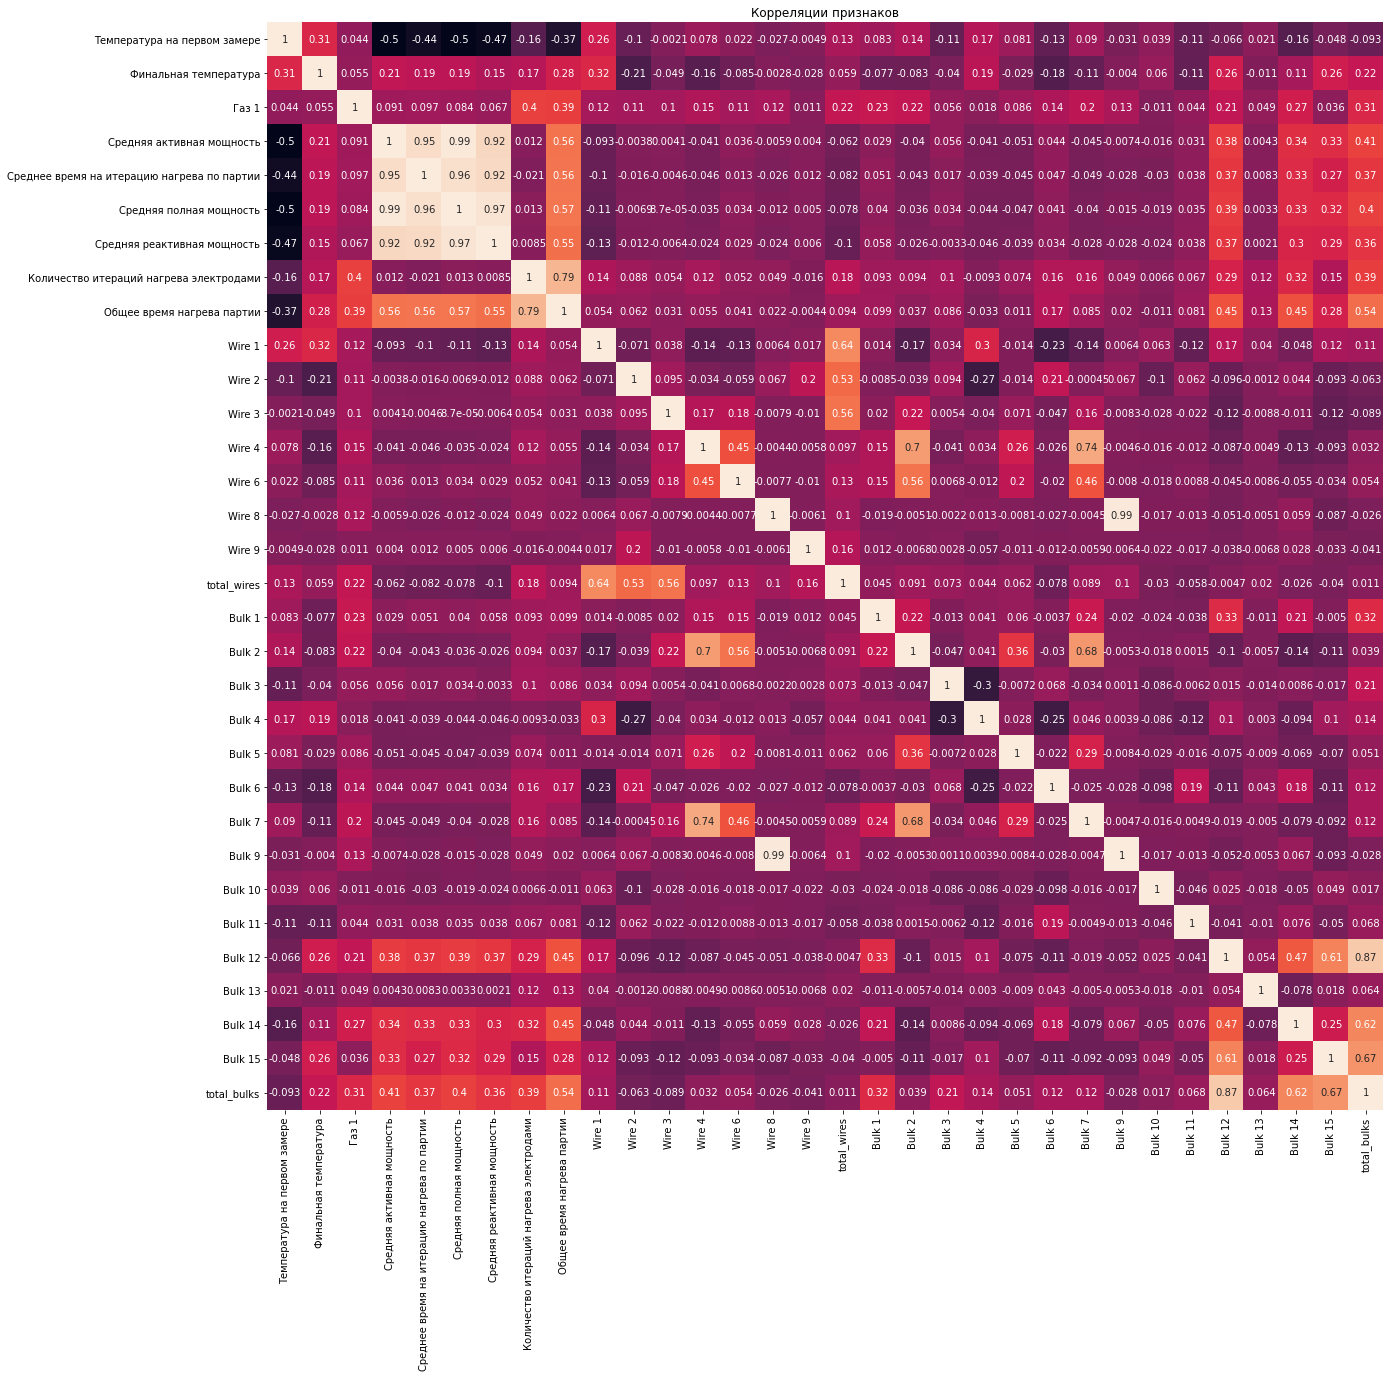

In [87]:
fig = plt.figure(figsize=(20,20))


sns.heatmap(data.drop(columns=['key']).corr(),
            annot = True,
            cbar=False)
plt.title('Корреляции признаков')

На графике нас прежде всего интересует с какими признаками коррелирует `Финальная температура`, т.к. именно ее мы и будем предсказывать.

Видно, что температура прямо коррелирует с общим временем нагрева партии, добавлением проволочного материала `Wire 1`, сыпучих материалов `Bulk 12` и `Bulk 15` и общем количеством добавленных материалов. В то же время, сильно линейной зависимости нет ни с одним из признаков.

## Обучение моделей

### Разделение датасета на выборки

Отделим целевой признак от остального датасета, уберем номера партий и разобьем весь датасет на две части — 75% на обучающую выборку и 25% на тестовую

In [88]:
target = data['Финальная температура']                          # определяем целевой признак
features = data.drop(columns=['Финальная температура','key'])          

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=101022)

Проверим размерность выборок:

In [89]:
features_train.shape

(1723, 31)

In [90]:
features_test.shape

(575, 31)

In [91]:
target_train.shape

(1723,)

In [92]:
target_test.shape

(575,)

Таким образом, модель будет обучена на данных по 1742 партиям и протестирована на данных по 581 партии

### Обучение модели по алгоритму случайного леса

В работе мы попробуем обучить две модели — более простую по алгоритму случайного леса и более сложную с применением градиентного бустинга.

In [93]:
model = RandomForestRegressor(random_state = 101022) #создаем объект модели

Качество модели будет проверено путем кросс-валидации — данный метод проверки модели уже встроен в объект библиотеки sklearn GridSearchCV для поиска лучших гиперпараметров.

In [94]:
%%time
# создаем словарь с параметрами, которые переберем

parametrs = {'n_estimators' : [10,100,200],
             'min_samples_split': range(2,8),
             'max_depth' : range(1,20,2)
             }

grid = GridSearchCV(model, parametrs, scoring = 'neg_mean_absolute_error', cv=5) # в качестве метрики MAE
grid.fit(features_train, target_train)
grid.best_params_

Wall time: 13min 23s


{'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 200}

Посмотрим на метрику лучшей модели:

In [95]:
grid.best_score_

-6.166733901250474

На обучающей выборке MAE модели с лучшими гиперпараметрами при проверке кросс-валидацией составляет 6,16. 

Посмотрим, какую метрику даст следующая модель.

### Обучение модели CatBoostRegressor

In [96]:
model = CatBoostRegressor(random_state = 101022, loss_function ='MAE',verbose=100)

grid = {'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'max_depth': [1, 2, 4, 6, 10, 50, 100]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       cv=5,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1577.6894986	test: 1577.1448110	best: 1577.1448110 (0)	total: 320ms	remaining: 5m 19s
100:	learn: 577.9860279	test: 577.4608346	best: 577.4608346 (100)	total: 385ms	remaining: 3.43s
200:	learn: 212.0782405	test: 211.5627101	best: 211.5627101 (200)	total: 445ms	remaining: 1.77s
300:	learn: 78.1745194	test: 77.6717356	best: 77.6717356 (300)	total: 501ms	remaining: 1.16s
400:	learn: 29.2441921	test: 28.8233277	best: 28.8233277 (400)	total: 585ms	remaining: 874ms
500:	learn: 12.5130708	test: 11.8390723	best: 11.8390723 (500)	total: 646ms	remaining: 643ms
600:	learn: 8.2849778	test: 7.5335600	best: 7.5335600 (600)	total: 706ms	remaining: 469ms
700:	learn: 7.4116043	test: 6.7854021	best: 6.7854021 (700)	total: 768ms	remaining: 328ms
800:	learn: 7.0799538	test: 6.6369954	best: 6.6369954 (800)	total: 826ms	remaining: 205ms
900:	learn: 6.9329390	test: 6.5509465	best: 6.5509465 (900)	total: 883ms	remaining: 97ms
999:	learn: 6.8203667	test: 6.4591464	best: 6.4591464 (999)	total: 940ms	r

На графике видно, что модель бытсро переобучается — на тестовых данных МАЕ стремится к нулю, но при проверке на тестовых кросс-валидацией резко возрастает.

Лучшие результаты дала модель с `learning_rate` равным 0.1 и глубиной 2 — ее МАЕ равняется 5.54 — и т.к. этот показатель ниже, чем у модели Случайного леса, именно ее мы и проверим на тестовой выборке.

### Проверка работы модели на тестовой выборке и сравнение с константной моделью

Обучим модель с лучшими гиперпараметрами и рассчитаем MAE на тестовой выборке.

In [97]:
model_CBR = CatBoostRegressor(random_state = 101022,
                              loss_function ='MAE',
                              learning_rate = 0.1,
                              max_depth = 2)

model.fit(features_train, target_train)

predictions = model.predict(features_test)

mae_test = mean_absolute_error(target_test,predictions)

0:	learn: 7.8288440	total: 816us	remaining: 816ms
100:	learn: 5.7705027	total: 66.1ms	remaining: 588ms
200:	learn: 5.5617214	total: 127ms	remaining: 505ms
300:	learn: 5.4425617	total: 188ms	remaining: 437ms
400:	learn: 5.3607312	total: 253ms	remaining: 377ms
500:	learn: 5.2858557	total: 313ms	remaining: 312ms
600:	learn: 5.2398940	total: 374ms	remaining: 248ms
700:	learn: 5.2058717	total: 436ms	remaining: 186ms
800:	learn: 5.1759007	total: 510ms	remaining: 127ms
900:	learn: 5.1516673	total: 583ms	remaining: 64ms
999:	learn: 5.1320788	total: 666ms	remaining: 0us


In [98]:
mae_test

5.8734868792464985

МАЕ оказалось чуть ниже 6 градусов — однако, пока сложно сказать много это или мало — посмотрим на графике, на сколько модель ошибалась по конкретным объектам (партиям) и сравним с константной моделью.

In [99]:
# создаем дополнительный датафрейм из данных с реальной температурой партий в тестовой выборке
df_1 = pd.DataFrame(target_test).reset_index().rename(columns={'index':'Номер партии',
                                                             'Финальная температура':'Финальная температура, факт'})

In [100]:
# добавляем столбец с прогнозом
df_1['Финальная температура, прогноз'] = pd.Series(predictions)

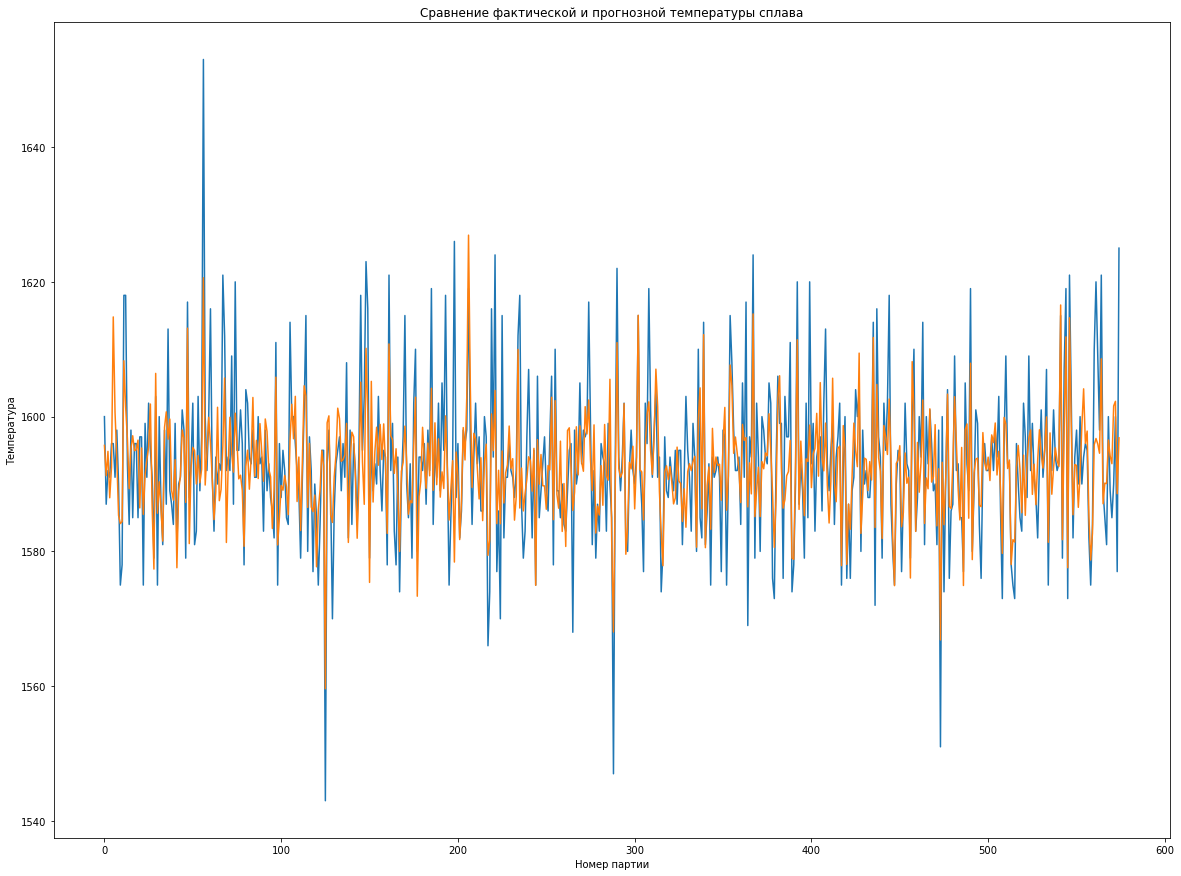

In [101]:
plt.figure(figsize=(20,15))
sns.lineplot(data=df_1,
             x = df_1.index,
             y = 'Финальная температура, факт',
             legend='auto')
sns.lineplot(data=df_1,
             x = df_1.index,
             y = 'Финальная температура, прогноз')
plt.title('Сравнение фактической и прогнозной температуры сплава')
plt.xlabel('Номер партии')
plt.ylabel('Температура')
plt.show()


На графике видно, что реальная температура имеет больший разброс значений, а модель предсказывает только часть "выбросов"

Сравним ее работу с константной моделью:

In [102]:
model_dummy = DummyRegressor(strategy="mean") #константная модель

#обучаем на тренировочных данных

model_dummy.fit(features_train, target_train)

#сохраянем предсказания
predictions_dummy  = model_dummy.predict(features_test)  

#считаем smape
mae_dummy =mean_absolute_error(target_test, predictions_dummy)

In [103]:
mae_dummy

8.476368316132127

Константное предсказание дает МАЕ ~ 8.47 градусов против ~ 5.87 у нашей модели. В случае если такая разница позволит сэкономить электроэнергию, она должна быть запущена в прод.

### Вывод по работе

В начале исследования мы изучили данные по нагреву каждой партии электродами, добавлении сыпучих и проволочных материалов, ииспользованным инертным газам для продува.

Перед тем как перейти к обучению модели, была выполнена преобработка данных:
- удалены записи с аномально низкой температурой сплава (менее 1500 градусов), т.к. это потенциально дефектыне партии или ошибка измерений;
- отброшены партии для которых нет последних измерений температуры или измерения отсутствуют целиком;
- удалены партии, в которых применялись редкие легирующие добавки — как проволочные, так и сыпучие;
- удалены выбросы в данных о работе электородов (отрицательная активная мощность);
- данные были сагреггированы по партиям во всех датасетах;
- были рассчитыны дополнительные признаки — средняя полная, активная и реактивная мощности, общее время нагрева партии, количество итераций нагрева партии;
- заполнены пропуски по неиспользуемым легирующим добавкам.

Все данные были разделены на обучающую и тестовую выборки в пропорции 3:1.

После предобработки данных путем кросс-валидации мы проверили работу двух моделей — модели по алгоритму Случайного леса и модели с применением градиентого бустинга CatBoostRegressor. В качестве целевой метрики мы выбрали среднюю абсолютную ошибку  MAE.

Модель с применением бустинга показала лучший результат и ее работу мы проверили на тестовой выборке и сравнили с константной моделью. На тестовой выборке модель показа МАЕ ~ 5.87 градусов т.е. грубо говоря в среднем модель ошибкается на 5.87 градусов при прогнозе финальной температуры партии. Константная модель дала МАЕ 8.47 градусов. Т.е. образом наша модель дает на 2.6 градусов более точный прогноз — если такая разница дает экономию производству, то модель можно применять на практике.

# Отчет

# Описание проекта

Исследование проводилось на основе данных от металлургического комбината, который  и выступал заказчиком. Цель исследования — сократить потребление электроэнергии на этапе обработки стали за счет предсказания температуры стали.

# Данные

Для лучшего понимания данных, необходимо описать технологический процесс легирования стали.

Сталь обрабатывают в металлическом ковше, облицованным изнутри огнеупорным кирпичом, вместимостью около 100 тонн. В ковш заливают расплавленную сталь и подогревают до нужной температуры графитовыми электродами, установленными в крышке ковша. 

Затем из сплава выводится сера (десульфурация), и за счет добавления примесей корректируется его химический состав . Для проверки состава отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

Данные были предоставлены заказчиком из разных источников и разбиты на несколько наборов:

- `data_arc.csv` — данные об работе электродов;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В некоторых наборах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

1. Загрузка данных и их первичный анализ;
2. Предобработка данных:
    - обработка аномалий и пропусков;
    - расчет дополнительных признаков;
    - расчет целевого признака;
    - объединение данных в сборный датасет с агрегацией по номеру партии;
3. Обучение моделей:
    - разбивка датасета на обучающую и тестовую выборки;
    - обучение нескольких моделей и проверка их работы кросс-валидацией;
    - проверка работы лучшей модели на тестовой выборке;
4. Составление отчета по работе и рекомендаций по использованию модели.

# Предобработка данных

При первичном анализе данных в них был замечен ряд проблем:
- разное количество партий, по которым имелись данные;
- аномальные и редкие значения по некоторым признакам.

В ходе решения данных проблем из данных о температуре были удалены записи по партиям, в которых:
- измерение температуры показало значение менее 1500 градусов — по технологии, она не может быть ниже и такие партии являются браком или имеется ошибка измерения;
- нет последнего измерения температуры;

Мы также отбросили партии, в которых в качестве легирующих добавок были использованы материалы, которые почти не встречались в датасете — данных по ним не достаточно для обучения моделей. Кроме того, была удалена партия, по которой имелось аномальное значение мощность (отрицательное значение).



После удаления аномальных и редких значений, мы объединили все данные в один датасет, агрегировав записи по номеру партии, а затем были рассчитаны дополнительные признаки для обучения моделей:
- cредние активные, реактивыне и полные мощности по партии;
- общее время нагрева партии;
- температура на первом замере (до начала легирования);
- общее количество добавленных сыпучих и проволочных материалов;
- количество итераций нагрева партии.

На выходе мы получили данные по 2298 партиям и 32 признака для модели, один из которых являлся целевым.

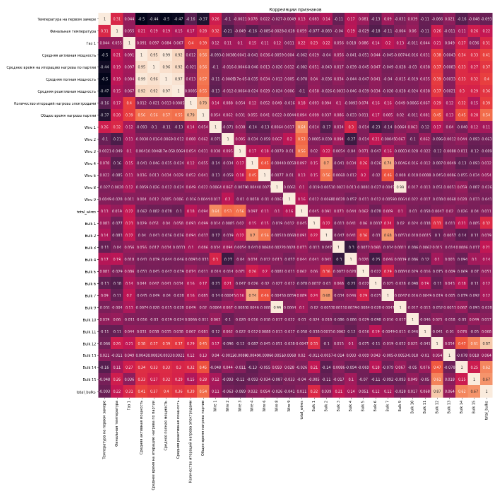

# Обучение моделей

Перед обучением моделей, мы разделили весь набор данных на обучающую (75%) и тестовую (25%) выборки.

Нами было обучено два семейства моделей — модель по алгоритму Случайного леса и модель с прменением градиентного бустинга CatboostRegressor — с различными гиперпараметрами. Проверка их работы осуществлялась путем кросс-валидации. В качестве целевой метрики была выбрана средняя абсолютная ошибка (МАЕ)

Лучший результат показала модель CatBoostRegressor с `learning_rate` равным 0.1 и глубиной дерева 2 — ее MAE при проверке кросс-валидацией 5.54. Именно ее работу мы протестировали на тестовой выборке.

На тесте модель показа МАЕ 5.87 — эта метрика на 2.6 градуса превосходит работу константной модели (ее МАЕ 8.47) и должна позволить металлургическому комбинату сэкономить электроэнергию.



Ниже приведен график реальных показателей температуры и прогнозов модели:

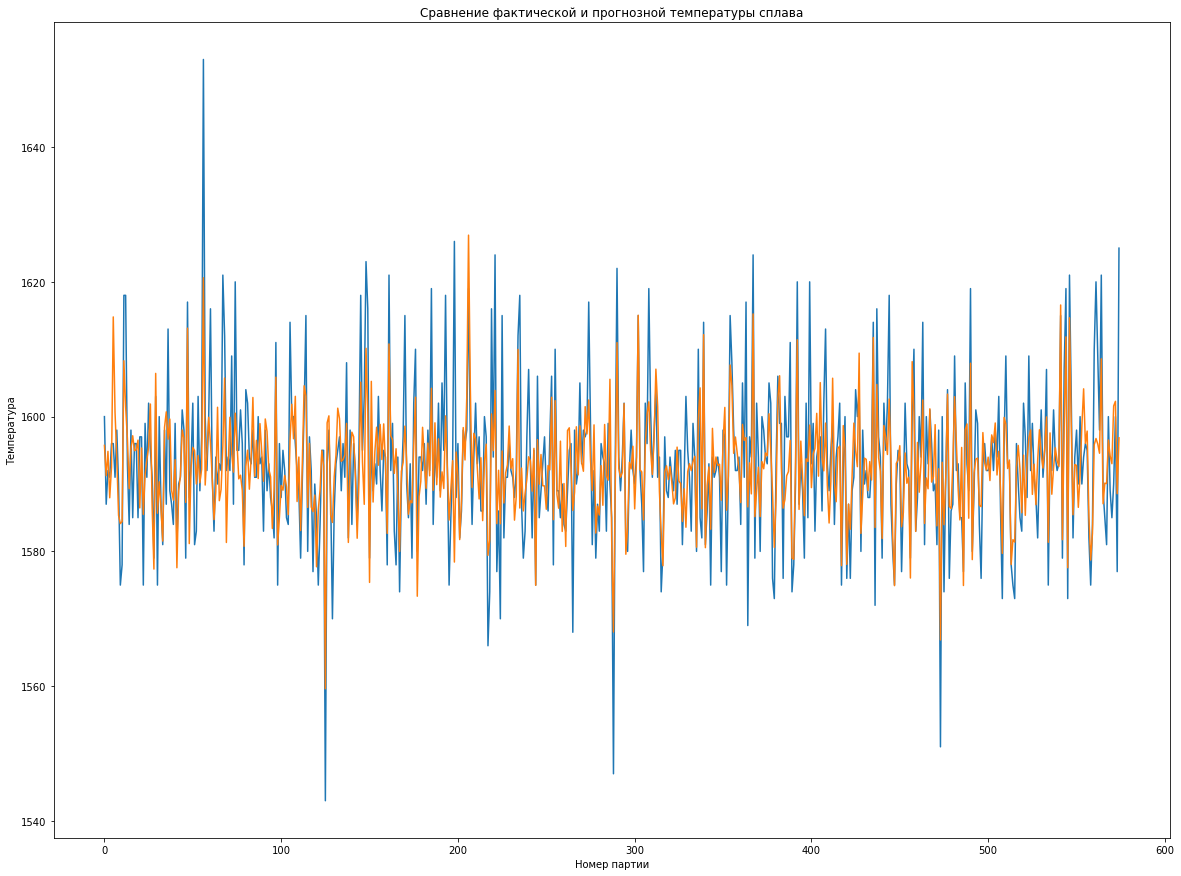

На графике видно, что модель пока плохо прогнозирует "выбросы" — партии с аномально высоким или низким значением температуры.

# Рекомендации

Модель опережает константную модель, но о размерах достигнутой экономии от ее использования может судить только технолог производства.

Для улучшения дальнейшей работы модели рекомендуется:
- продолжать накапливать данные — тогда появится достаточное количество наблюдений для более редких легирующих добавок;
- исправить систему учета температуры, так чтобы данные по партиям не приходилось отбрасывать — при работе с текущими данными мы потеряли около 20% партий.